In [9]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import networkx as nx


from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

from visu_utils import *


In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:

PREFIX = "mteb_ds"
df = pd.read_csv('exported_data/normalized_13.df')

# white grid
sns.set_style("whitegrid")


In [12]:
# MODELS_MAIN_EXPES

In [13]:


df = text_embeddings_metadata_results_preprocessing(df, short_names=True, models=MODELS_MAIN_EXPES)

In [14]:
METRIC = "I(X_1->X_2)/d_2"
table = make_table_pivot(metric=METRIC, df=df)


/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)


In [15]:
# Filter 


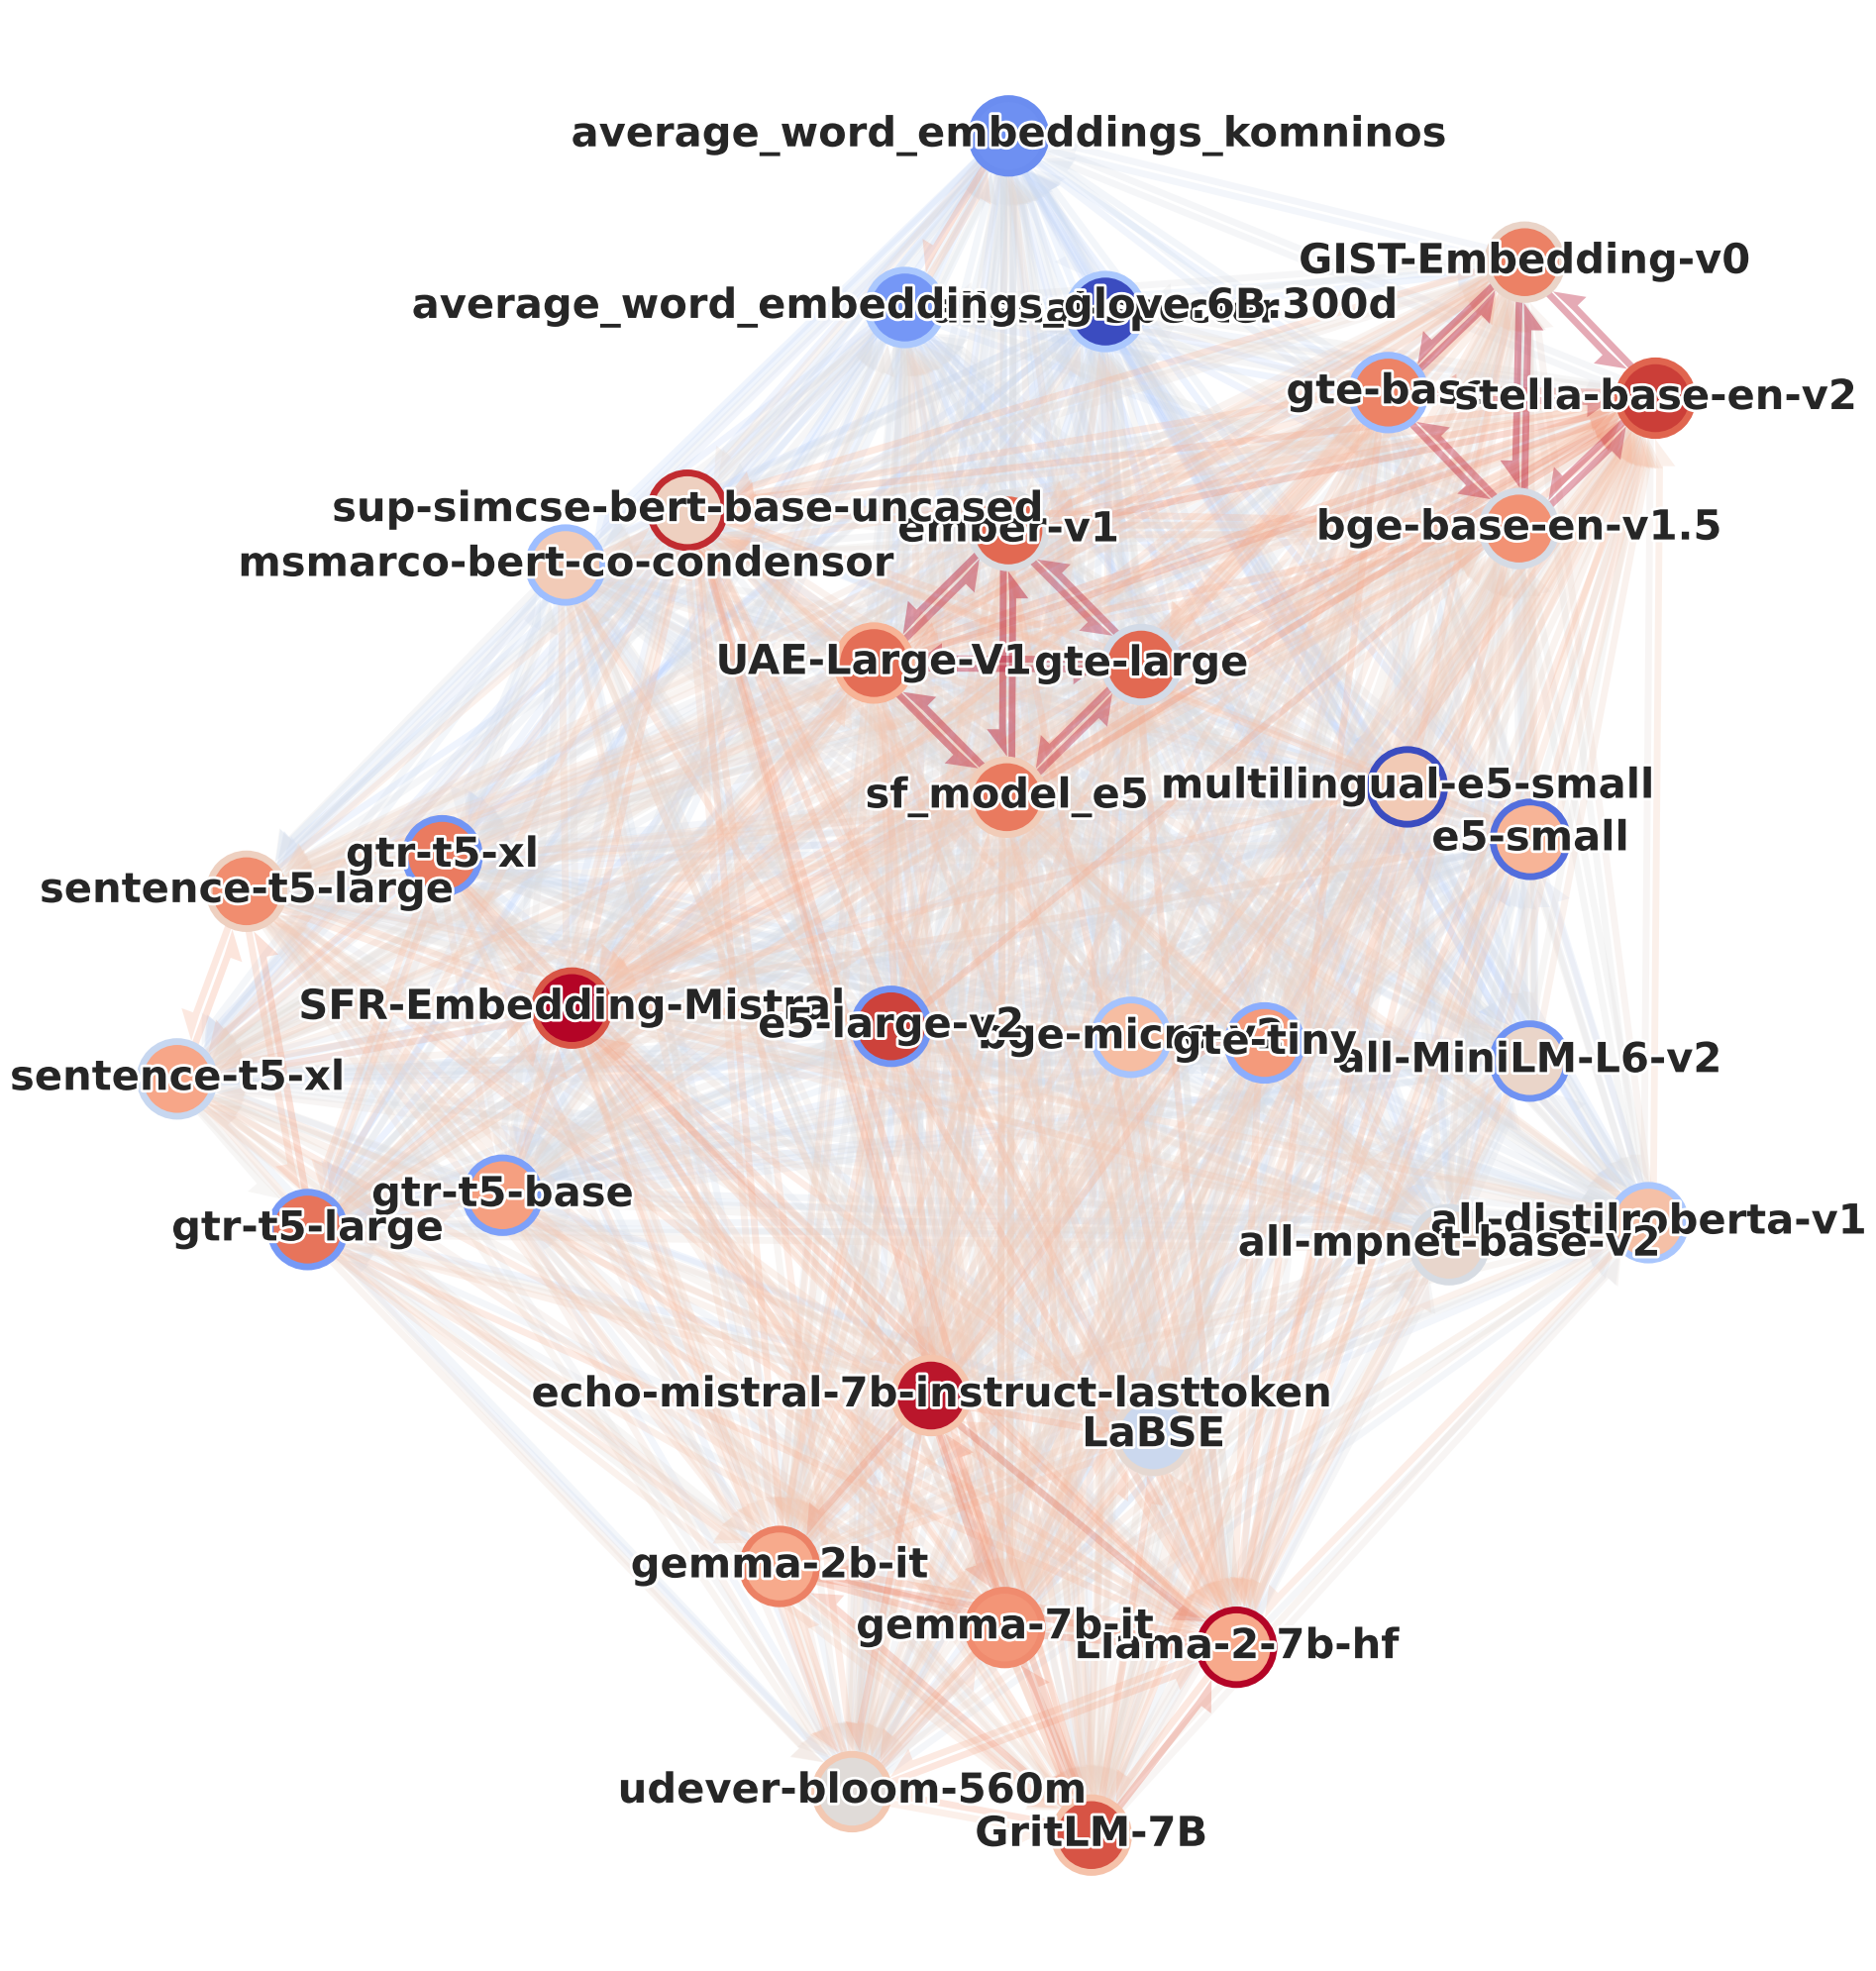

In [42]:


edge_ratio = 0.3


G= nx.from_pandas_adjacency(table, create_using=nx.DiGraph)
G.remove_edges_from(nx.selfloop_edges(G))

communities = louvain_communities(G, resolution=1.1)
communities = list(communities)


cmap = sns.color_palette("coolwarm", as_cmap=True)

avg_weight = {n : np.median([d[2]['weight'] for d in G.out_edges(n, data=True)]) for n in G.nodes()}
avg_income = {n : np.median([d[2]['weight'] for d in G.in_edges(n, data=True)]) for n in G.nodes()}


node_to_community = {node: i for i, community in enumerate(communities) for node in community}


node_color = {node: avg_weight[node] for node in G.nodes()}
node_color = {node: (node_color[node] - min(node_color.values())) / (max(node_color.values()) - min(node_color.values())) for node in node_color}
node_color = {node: cmap(node_color[node]) for node in G.nodes()}

node_edge_color = {node: avg_income[node] for node in G.nodes()}
node_edge_color = {node: (node_edge_color[node] - min(node_edge_color.values())) / (max(node_edge_color.values()) - min(node_edge_color.values())) for node in node_edge_color}
node_edge_color = {node: cmap(node_edge_color[node]) for node in G.nodes()}


# For each node only keep the top incoming edges
# for node in G.nodes():
#     in_edges = sorted(G.in_edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)
#     for edge in in_edges[int(len(in_edges) * edge_ratio):]:
#         G.remove_edge(*edge[:2])


node_labels = {node: node for node in G.nodes()}

edge_color = {edge: G.edges[edge]['weight'] for edge in G.edges()}
# normalize edge 
# edge_color = {edge: (edge_color[edge] - min(edge_color.values())) / (max(edge_color.values()) - min(edge_color.values())) for edge in edge_color}
edge_color = {edge: cmap(edge_color[edge]) for edge in edge_color}
max_edge = max(e[2]['weight'] for e in G.edges(data=True))


# normalize edge alpha
min_alpha = 0.2
max_alpha = 0.4
edge_alpha = {edge: G.edges[edge]['weight'] for edge in G.edges()}
edge_alpha = {edge: (edge_alpha[edge] - min(edge_alpha.values())) / (max(edge_alpha.values()) - min(edge_alpha.values())) * (max_alpha - min_alpha) + min_alpha for edge in edge_alpha}

# edge width
min_edge_width = 0.05
max_edge_width = 0.5
edge_width = {edge: G.edges[edge]['weight'] for edge in G.edges()}
edge_width = {edge: (edge_width[edge] - min(edge_width.values())) / (max(edge_width.values()) - min(edge_width.values())) * (max_edge_width - min_edge_width) + min_edge_width for edge in edge_width}


fig, ax = plt.subplots(figsize=(30, 20))

graph = Graph(G, node_layout_kwargs=dict(node_to_community=node_to_community, pad_by=0.1), node_layout="community", node_color=node_color, node_labels=node_labels, edge_color=edge_color, ax=ax, node_label_fontdict={'fontsize': 30, 'fontweight': 'bold'}, node_edge_color=node_edge_color, edge_layout="straight", edge_alpha=edge_alpha, arrows=True, scale=(1.1, 1.5))



# add white contour to all texts in the figure
for text in plt.gca().texts:
    text.set_path_effects([patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal()])

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_edge))
sm._A = []
# cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.5, pad=0.05)

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_mis_graph_community_{sanitize_metric_name(METRIC)}.pdf")
# make sure the folder exists
path.parent.mkdir(parents=True, exist_ok=True)
fig.tight_layout()
fig.savefig(path, bbox_inches='tight', dpi=300)


# Make heatmap of the adjacency matrix

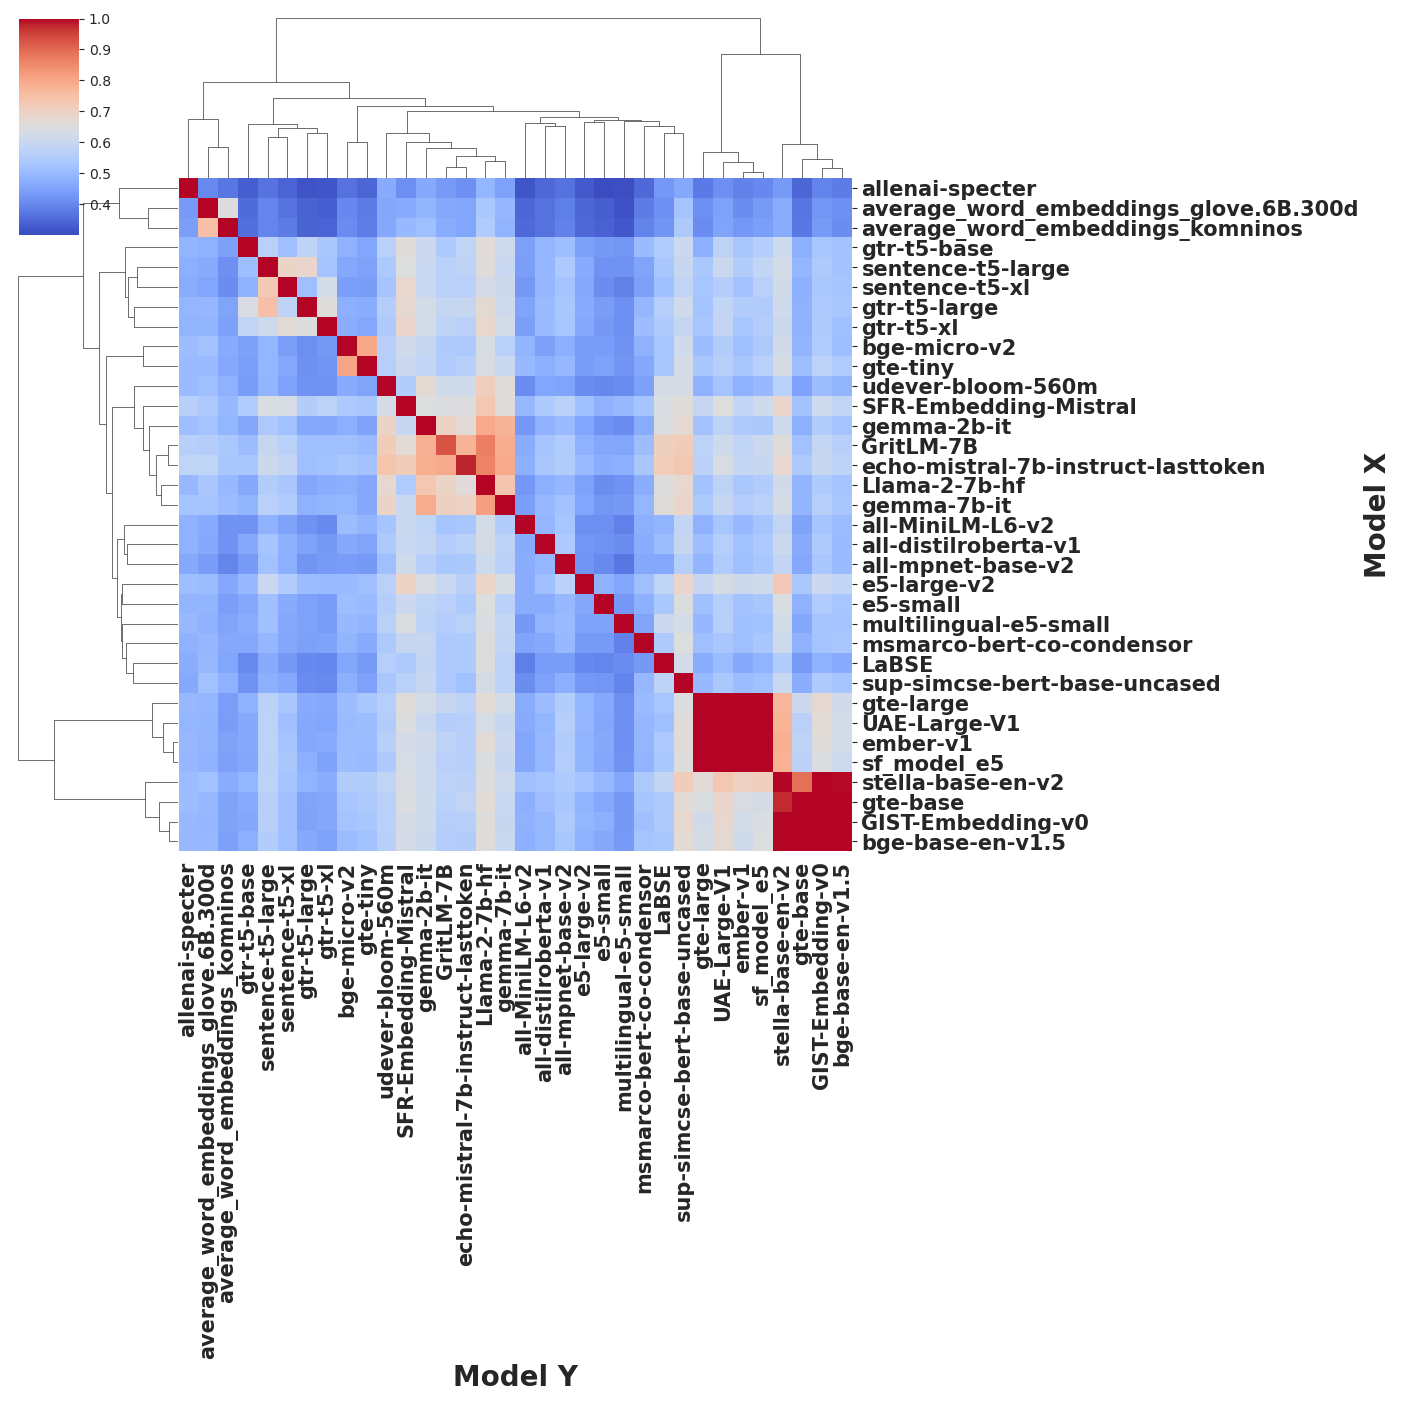

In [38]:

from scipy.cluster.hierarchy import linkage
link = linkage(table, method="ward")

cluster = sns.clustermap(table, row_linkage=link, col_linkage=link, figsize=(12, 12), cmap='coolwarm', annot=False, fmt=".1f", vmax=1)

# make labels bigger and bold and rename in model X and model Y
cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xticklabels(), fontsize=15, fontweight='bold')
cluster.ax_heatmap.set_yticklabels(cluster.ax_heatmap.get_yticklabels(), fontsize=15, fontweight='bold')
cluster.ax_heatmap.set_xlabel("Model Y", fontsize=20, fontweight='bold')
cluster.ax_heatmap.set_ylabel("Model X", fontsize=20, fontweight='bold')

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_mis_graph_clustermap_{sanitize_metric_name(METRIC)}.pdf")
# make sure the folder exists
path.parent.mkdir(parents=True, exist_ok=True)
cluster.savefig(path, bbox_inches='tight', dpi=300)
